In [97]:
# loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models
from torchvision import transforms as T

from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage import io
from PIL import Image

import os
import shutil
import time
import tarfile
import copy

%matplotlib inline

In [109]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Script is running on {device}')

Script is running on cuda:0


In [17]:
# setting up the paths
base_dir = os.path.abspath('/kaggle/working')
data_dir = os.path.join(base_dir, 'data')
images_train_dir = os.path.join(data_dir, 'images/train')
images_val_dir = os.path.join(data_dir, 'images/val')
images_temp_dir = os.path.join(data_dir, 'testSet_resize')

## Getting dataset and split images to train and validation directories

In [9]:
# make directories for training and validation sets
os.makedirs(images_train_dir, exist_ok=True)
os.makedirs(images_val_dir, exist_ok=True)

In [4]:
# download the dataset
!wget http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz

--2020-02-17 08:45:26--  http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2341250899 (2.2G) [application/octet-stream]
Saving to: ‘testSetPlaces205_resize.tar.gz’

testSetPlaces205_re 100%[===================>]   2.18G  9.46MB/s    in 3m 32s  

2020-02-17 08:48:59 (10.5 MB/s) - ‘testSetPlaces205_resize.tar.gz’ saved [2341250899/2341250899]



In [10]:
# extract the tar file
with tarfile.open(base_dir + '/testSetPlaces205_resize.tar.gz') as t:
    t.extractall(data_dir)

In [18]:
fnames = os.listdir(images_temp_dir)
print('Total files: {}'.format(len(fnames)))

Total files: 41000


In [22]:
# remove the tar file to release disk space
!ls
!rm testSetPlaces205_resize.tar.gz
!ls

__notebook_source__.ipynb  data  testSetPlaces205_resize.tar.gz
__notebook_source__.ipynb  data


In [23]:
# move images to training and validation directories
for i, file in enumerate(fnames):
    if i < 1000:
        # move the first 1000 images to validation dir
        shutil.move(images_temp_dir + '/' + file, images_val_dir + '/' + file)
    else:
        # move remaining 40000 images to training dir
        shutil.move(images_temp_dir + '/' + file, images_train_dir + '/' + file)

In [24]:
# remove the temp images directory
!rm -r {images_temp_dir}

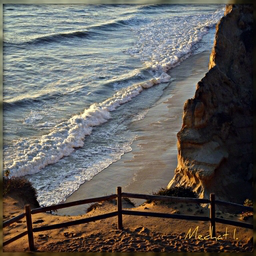

In [71]:
# show an image
display(Image.open(os.path.join(images_val_dir, fnames[0])))

## Prepairing datasets

In [110]:
class ColorizeDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.images = os.listdir(root)
        self.transforms = transforms
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.images[idx])
        img_original = Image.open(img_path).convert('RGB')
        if self.transforms is not None:
            img_original = self.transforms(img_original)
            
        img_original = np.asarray(img_original)
        img_lab = rgb2lab(img_original)
        img_lab = (img_lab + 128) / 255
        img_ab = img_lab[:, :, 1:3]
        img_ab = torch.from_numpy(img_ab.transpose(2, 0, 1)).float()
        img_gray = rgb2gray(img_original)
        img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
        
        return img_gray, img_ab
    
    def __len__(self):
        return len(self.images)

In [113]:
tfms_train = T.Compose([T.RandomResizedCrop(224),
                        T.RandomHorizontalFlip()])
tfms_val = T.Compose([T.Resize(256),
                      T.CenterCrop(224)])

datasets = {
    'train': ColorizeDataset(images_train_dir, tfms_train),
    'val': ColorizeDataset(images_val_dir, tfms_val)
}

dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(datasets['val'], batch_size=64, shuffle=False)
}

## Defining the model

In [35]:
class ColorizationNet(nn.Module):
    def __init__(self, input_size=128):
        super().__init__()
        MIDLEVEL_FEATURE_SIZE = 128
        
        ## First half: ResNet
        resnet = models.resnet18(num_classes=365)
        # Change first conv layer to accept single-channel (grayscale) input
        # torch.Size([64, 3, 7, 7]) --> torch.Size([64, 1, 7, 7])
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
        # Extract midlevel features from ResNet-gray
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])
        
        ## Second half: Upsampling
        self.upsample = nn.Sequential(
            nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2)
        )
    
    def forward(self, input):
        # Pass input through ResNet-gray to extract features
        midlevel_features  = self.midlevel_resnet(input)
        
        # Upsample to get colors
        output = self.upsample(midlevel_features)
        
        return output

In [114]:
# create model and move it to selected device (GPU or CPU)
model = ColorizationNet()
model = model.to(device)

## Train the model

In [115]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

In [123]:
def train_model(model, criterion, optimizer, epochs=30):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000.0
    
    losses = {
        'train': [],
        'val': []
    }
    
    model = model.to(device)
    
    print(f'{epochs} epochs training started...\n')
    for e in range(epochs):        
        epoch_start = time.time()
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.forward(inputs)
                    loss = criterion(outputs, inputs)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item()
            else:
                epoch_loss = running_loss / len(dataloaders[phase])
                losses[phase].append(epoch_loss)
                
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

        epoch_elpased_time = time.time() - epoch_start
        print(f'Epoch {e+1}/{epochs}:')
        print('-'*80)
        print('Epoch completed in {:.0f}m {:.0f}s'.format(epoch_elpased_time // 60, epoch_elpased_time % 60))
        print('Train loss: {:.5f} --- Validation loss: {:.5f}\n'.format(losses['train'][-1], losses['val'][-1]))
    
    print('\n')
    time_elpased = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elpased // 60, time_elpased % 60))
    print('Best validation loss: {:.5f}'.format(best_loss))
                
    return best_model_wts

In [124]:
best_model_wts = train_model(model, criterion, optimizer, epochs=4)

4 epochs training started...



/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([64, 1, 224, 224])) that is different to the input size (torch.Size([64, 2, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([40, 1, 224, 224])) that is different to the input size (torch.Size([40, 2, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/4:
--------------------------------------------------------------------------------
Epoch completed in 14m 35s
Train loss: 0.00331 --- Validation loss: 0.00541

4 epochs training started...

Epoch 2/4:
--------------------------------------------------------------------------------
Epoch completed in 14m 33s
Train loss: 0.00301 --- Validation loss: 0.00520

4 epochs training started...

Epoch 3/4:
--------------------------------------------------------------------------------
Epoch completed in 14m 31s
Train loss: 0.00288 --- Validation loss: 0.00495

4 epochs training started...

Epoch 4/4:
--------------------------------------------------------------------------------
Epoch completed in 14m 33s
Train loss: 0.00286 --- Validation loss: 0.00481



Training completed in 58m 12s
Best validation loss: 0.00481


In [125]:
# torch.save(best_model_wts, 'stage2_val-loss0.00481.pth')

In [126]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

## Helper functions

In [152]:
def to_rgb(in_gray, in_ab):
    color_img = torch.cat((in_gray, in_ab), 0).detach().numpy()
    color_img = color_img.transpose(1, 2, 0)
    color_img[:, :, 0:1] = color_img[:, :, 0:1] * 100
    color_img[:, :, 1:3] = color_img[:, :, 1:3] * 255 - 128
    color_img = lab2rgb(color_img.astype(np.float64))
    gray_img = in_gray.squeeze().detach().numpy()
    
    # plt.imshow(gray_img)
    plt.imshow(color_img)

In [129]:
inputs, targets = next(iter(dataloaders['val']))
inputs.shape, targets.shape

(torch.Size([64, 1, 224, 224]), torch.Size([64, 2, 224, 224]))

In [154]:
in_gray = inputs[2]
target_ab = targets[2]

In [155]:
model.eval()
in_gray = in_gray.unsqueeze(0)

out_ab = model(in_gray.to(device))
out_ab.shape

torch.Size([1, 2, 224, 224])

In [156]:
in_gray = in_gray.squeeze(0)
in_gray = in_gray.cpu()
out_ab = out_ab.squeeze(0)
out_ab = out_ab.cpu()
out_ab.shape

torch.Size([2, 224, 224])

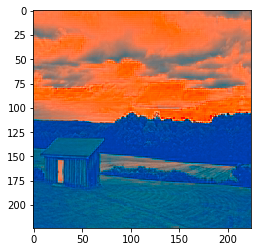

In [157]:
to_rgb(in_gray, out_ab)

In [147]:
c = torch.cat((in_gray, out_ab), 0)
c.shape

torch.Size([3, 224, 224])